# Physics simulator with uncertainty

In [1]:
import Numeric.Hamilton (stepHam, System, Phase (Phs, phsPositions, phsMomenta), mkSystem', Config (cfgPositions, cfgVelocities, Cfg), toPhase)
import GHC.TypeLits (KnownNat)
import Numeric.LinearAlgebra.Static hiding ((#))
import qualified Data.Vector.Sized                   as V
import Control.Monad.Bayes.Class
import Data.Maybe (fromMaybe)
import Control.Monad.Bayes.Sampler.Strict
import Control.Monad
import Diagrams.Prelude hiding (normal)
import Diagrams.Prelude (V2(..), (#))
import qualified Diagrams.Backend.Cairo as C
import Data.List


:e PatternSynonyms
:e ViewPatterns
:e RankNTypes
:e DataKinds
:e FlexibleContexts
:e GADTs




In [2]:

pattern V1 :: a -> V.Vector 1 a
pattern V1 x <- (V.head->x)
  where
    V1 x = V.singleton x

type V2 = V.Vector 2
pattern V2 :: a -> a -> V2 a
pattern V2 x y <- (V.toList->[x,y])
  where
    V2 x y = V.fromTuple (x, y)

fromDouble :: Double -> R 1
fromDouble = fromList  . (:[])

-- couldn't find the right conversion function...
toDouble :: R 1 -> Double 
toDouble = read . take 8 . tail . show

There's a number of ways a physics simulator could be used in a probabilistic context. The simplest is to have a prior over initial states, and evolve a system forward.

As an example, here we use the `hamilton` classical physics engine in Haskell, which is a very simple, but coordinate independent, physics simulator.

We can define a 1D harmonic oscillator like:

In [3]:
system1 :: (System 1 1)
system1 = mkSystem' 1 
        id 
    
        (\(V1 x) -> x ** 2 / 2)
        
system2 :: (System 1 1)
system2 = mkSystem' 1 
        id 
    
        (\(V1 x) -> x ** 2)
    
-- we could have uncertainty over the Hamiltonian itself, but let's not for now
system = uniformD [system1]

and an initial distribution over phase space:

In [4]:
phase :: MonadSample m => m (Phase 1)
phase = do
  pos <- (20*) <$> random
  return $ Phs {phsPositions = fromDouble pos, phsMomenta = 10}

`pushforward` is then a distribution over paths of the system, numerically evolved forward according to the oscillator Hamiltonian.

In [5]:
pushforward :: MonadSample m => m [Double]
pushforward = do
    initial <- phase
    sys <- system
    let new = [stepHam stepSize sys initial | stepSize <- [0.1,0.2..10]]
    return (toDouble . phsPositions <$> initial:new)
    
pairs <- sampler $ replicateM 30 pushforward

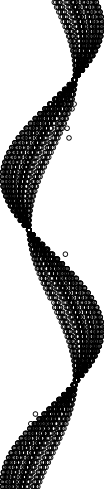

In [6]:
toD x = translateX x $ circle 1
diagram $ vsep 0.1 $ [mconcat $ toD <$> x | x <- transpose pairs]

Time is the y-axis of this diagram, going downwards. Each circle is a sampled position of the oscillating particle. You can see that this has the nice property that all the uncertainty disappears at certain points, which is exactly what you'd expect from an oscillator.

<!-- ## Chaotic systems

Looking at the evolution of a distribution is a good way to visualize chaos. For example, if we evolve a double pendulum forward in time, from a low variance distribution, we end up with a high variance distribution quickly. -->